## Exercise 1: Prompt Engineering

Let's consider LLAMA as our starting point. In the following, we see a typical prompt feeding and text generation with LLAMA

In [ ]:
from huggingface_hub import login

import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import datetime


model_id = "meta-llama/Llama-3.2-3B"
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, device_map="cuda")
tokenizer = AutoTokenizer.from_pretrained(model_id)
device = "cuda"

query = "Tell me the capital of France."

prompt = f"Question: {query}\n\nAnswer:"  # Create the prompt for LLAMA (context + query)



#alternative 1: use the tokenizer and produce the output

def make_a_query(prompt, tokenizer, model):
    # Set pad_token_id if missing
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id

    # Tokenize the input with padding and truncation
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)

    # Generate a response
    output = model.generate(
        inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_new_tokens=200,  # Limit the number of new tokens generated (e.g., a single word)
        temperature=0.3,  # Reduce randomness
        repetition_penalty=2.0,  # Penalize repetition
        no_repeat_ngram_size=3,  # Avoid repeating bigrams
        do_sample=False,  # Make the output deterministic (not sampled)
        eos_token_id=tokenizer.eos_token_id,  # End generation at EOS token
        pad_token_id=tokenizer.pad_token_id  # Avoid padding tokens
    )

    # Decode the response into human-readable text
    response = tokenizer.decode(output[0], skip_special_tokens=True).strip()



    return response




#alternative 2: use the chat template and pipelines from huggingface


pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto",
)


outputs = pipe(
    prompt,
    max_new_tokens=200,  # Limit the number of new tokens generated (e.g., a single word)
    temperature=0.3,  # Reduce randomness
    repetition_penalty=2.0,  # Penalize repetition
    no_repeat_ngram_size=3,  # Avoid repeating bigrams
    do_sample=False,  # Make the output deterministic (not sampled)
    eos_token_id=tokenizer.eos_token_id,  # End generation at EOS token
    pad_token_id=tokenizer.pad_token_id  # Avoid padding tokens
)



print(make_a_query(prompt, tokenizer, model))

print(outputs[0]["generated_text"])



### Fitz

Reference libraries to install: pip install openai pymupdf faiss-cpu scikit-learn

PyMuPDF is a Python library that provides tools for working with PDF files (as well as other document formats like XPS, OpenXPS, CBZ, EPUB, and FB2). It's built on the MuPDF library, a lightweight, high-performance PDF and XPS rendering engine. With PyMuPDF, you can perform various tasks like reading, creating, editing, and extracting content from PDFs, images, and annotations.

In [ ]:
import fitz

#open an example pdf
doc = fitz.open("example2.pdf")

# Extract text from the first page
page = doc.load_page(0)
text = page.get_text("text")  # Use 'text' mode to get raw text



def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        text+=page.get_text()
    return text

print(extract_text_from_pdf("example2.pdf"))


### Example: Text Summarization

Let's ask LLAMA to perform a summarization of the example PDF.

In [ ]:



#define the prompt to ask for text summarization. 
text_summarization_prompt = "Write a concise summary of the main ideas in article below."      #define your prompt here
text = extract_text_from_pdf("example2.pdf")                          #load here the text of the article
p1 =  """Question: {PROMPT}. article: {BODY} \nAnswer:""".format(PROMPT=text_summarization_prompt, BODY=text)

#feed the prompt to llama
#print the result of text summarization into bullets
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

inputs = tokenizer(p1, return_tensors="pt", padding=True, truncation=True).to(device)



# Generate a response
output = model.generate(
    inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_new_tokens=300,  # Limit output to a reasonable size (adjust as needed)
    top_k=10,  # Sampling parameters
    num_return_sequences=1,  # Generate a single response
    temperature=0.7,  # Adjust randomness
    repetition_penalty=1.0,  # Reduce repetition
    length_penalty=1.0,  # Penalize longer responses
    eos_token_id=tokenizer.eos_token_id,  # End generation at EOS token
    pad_token_id=tokenizer.pad_token_id,  # Avoid padding tokens
    early_stopping=True  # Stop once the model generates the response
)

# Decode the response into human-readable text
r1 = tokenizer.decode(output[0], skip_special_tokens=True).strip()

print(r1)

### Adding a System Prompt

Llama was trained with a system message that set the context and persona to assume when solving a task. One of the unsung advantages of open-access models is that you have full control over the system prompt in chat applications. This is essential to specify the behavior of your chat assistant –and even imbue it with some personality–, but it's unreachable in models served behind APIs.


In [ ]:
#default standard system message from the Hugging Face blog to the prompt from above
system_prompt = "<<SYS>> You are a helpful, respectful and honest assistant. \
    Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, \
    unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses \
    are socially unbiased and positive in nature. If a question does not make any sense, or is not factually \
    coherent, explain why instead of answering something not correct. If you don't know the answer to a question, \
    please don't share false information. <</SYS>>"

#concatenate the system prompt with your pront and get the response
p2 =  """{SYS}\nQuestion: {PROMPT}. article: {BODY} \nAnswer:""".format(SYS=system_prompt, PROMPT=text_summarization_prompt, BODY=text)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

inputs = tokenizer(p2, return_tensors="pt", padding=True, truncation=True).to(device)



# Generate a response
output = model.generate(
    inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_new_tokens=300,  # Limit output to a reasonable size (adjust as needed)
    top_k=10,  # Sampling parameters
    num_return_sequences=1,  # Generate a single response
    temperature=0.7,  # Adjust randomness
    repetition_penalty=1.0,  # Reduce repetition
    length_penalty=1.0,  # Penalize longer responses
    eos_token_id=tokenizer.eos_token_id,  # End generation at EOS token
    pad_token_id=tokenizer.pad_token_id,  # Avoid padding tokens
    early_stopping=True  # Stop once the model generates the response
)

# Decode the response into human-readable text
r2 = tokenizer.decode(output[0], skip_special_tokens=True).strip()

print(r2)

### Customizing the System prompt

With Llama we have full control over the system prompt. The following experiment will instruct Llama to assume the persona of a researcher tasked with writing a concise brief.

Apply the following changes the original system prompt:
- Use the researcher persona and specify the tasks to summarize articles.
- Remove safety instructions; they are unnecessary since we ask Llama to be truthful to the article.


In [ ]:
new_system_prompt = """<<SYS>> You are a helpful assistant. 
    When summarizing an article or providing key points, you must:
    1. Use **bullet points** to list the main ideas.
    2. **Bullet points must be formatted like this:**
       - First key point goes here.
       - Second key point goes here.
       - Third key point goes here.
    3. Each bullet point should be one short sentence.
    4. Keep bullet points clear, concise, and easy to read.
    5. Make sure every distinct idea from the article is listed as a separate bullet point.
    6. Avoid paragraphs; only bullet points should be used in the output.
<</SYS>>"""

text_summarization_prompt2 = "Summarize the article below into bullet points. Format bullet points exactly as described above"

p3 =  """{SYS}\nQuestion: {PROMPT}. article: {BODY} \nAnswer (use bullet points exactly like this: - point 1):""".format(SYS=new_system_prompt, PROMPT=text_summarization_prompt2, BODY=text)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

inputs = tokenizer(p3, return_tensors="pt", padding=True, truncation=True).to(device)



# Generate a response
output = model.generate(
    inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_length=500,
    max_new_tokens=300,  # Limit output to a reasonable size (adjust as needed)
    top_k=10,  # Sampling parameters
    num_return_sequences=1,  # Generate a single response
    temperature=0.7,  # Adjust randomness
    repetition_penalty=1.0,  # Reduce repetition
    length_penalty=1.0,  # Penalize longer responses
    eos_token_id=tokenizer.eos_token_id,  # End generation at EOS token
    pad_token_id=tokenizer.pad_token_id,  # Avoid padding tokens
    early_stopping=True  # Stop once the model generates the response
)

# Decode the response into human-readable text
r3 = tokenizer.decode(output[0], skip_special_tokens=True).strip()

print(r3)

### Chain-of-Thought prompting

Chain-of-thought is when a prompt is being constructed using a previous prompt answer. For our use case to extract information from text, we will first ask Llama what the article is about and then use the response to ask a second question: what problem does [what the article is about] solve?



In [ ]:
import re

#define a prompt to ask what the article is about

#r3 is already ok to know what the article is about. we just split in two parts since we know the format of the response and we take only the data of interest


start_phrase = "Answer (use bullet points exactly like this: - point 1):"
r4 = r3.split(start_phrase, 1)[1].strip()

new_system_prompt = """<<SYS>> You are a helpful, respectful and honest assistant. \
    Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, \
    unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses \
    are socially unbiased and positive in nature. If a question does not make any sense, or is not factually \
    coherent, explain why instead of answering something not correct. If you don't know the answer to a question, \
    please don't share false information.
    Provide straight to the point answers, without bullet points.
<</SYS>>"""


#now embed the result of the previous prompt in a new prompt to ask some additional information (i.e., the year of foundation). you have to split the original prompt to create a new one

additional_info_prompt = """How many titles did AC Milan win?"""


p5 =  """{SYS}\nQuestion: {PROMPT}. article: {BODY} \nAnswer:""".format(SYS=new_system_prompt, PROMPT=additional_info_prompt, BODY=r4)


print("PROMPT:\n")
print(p5)
print("\n\n\n")

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id


inputs = tokenizer(p5, return_tensors="pt", padding=True, truncation=True).to(device)



# Generate a response
output = model.generate(
    inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_length=500,
    max_new_tokens=300,  # Limit output to a reasonable size (adjust as needed)
    top_k=10,  # Sampling parameters
    num_return_sequences=1,  # Generate a single response
    temperature=0.7,  # Adjust randomness
    repetition_penalty=1.0,  # Reduce repetition
    length_penalty=1.0,  # Penalize longer responses
    eos_token_id=tokenizer.eos_token_id,  # End generation at EOS token
    pad_token_id=tokenizer.pad_token_id,  # Avoid padding tokens
    early_stopping=True  # Stop once the model generates the response
)

# Decode the response into human-readable text
r5 = tokenizer.decode(output[0], skip_special_tokens=True).strip()

print(r5)


### Generating JSONs with Llama and providing Many-shot learning

Llama needs precise instructions when asking it to generate JSON. In essence, here is what works for me to get valid JSON consistently:

- Explicitly state — “ All output must be in valid JSON. Don’t add explanation beyond the JSON” in the system prompt.
- Add an “explanation” variable to the JSON example. Llama enjoys explaining its answers. Give it an outlet.
- Use the JSON as part of the instruction. See the “in_less_than_ten_words” example below.
Change “write the answer” to “output the answer.”


In [ ]:


#example addition to a prompt to deal with jsons
json_prompt_addition = "Output must be in valid JSON like the following example {{\"sport\": sport, \"explanation\": [in_less_than_ten_words]}}. Output must include only JSON."

new_system_prompt = """<<SYS>> You are a helpful, respectful and honest assistant. \
    Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, \
    unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses \
    are socially unbiased and positive in nature. If a question does not make any sense, or is not factually \
    coherent, explain why instead of answering something not correct. If you don't know the answer to a question, \
    please don't share false information.
    Provide straight to the point answers, without bullet points.
    Output must be in valid JSON like the following example {{\"sport\": sport, \"explanation\": [in_less_than_ten_words]}}. Output must include only JSON.
<</SYS>>"""

text_summarization_prompt3 = "Summarize the article below. Provide the different main aspects of AC Milan in JSON format in the format of the above example. Provide many different aspects"

#now generate a prompt by correctly concatenating the system prompt, the json prompt instruction, and a sports article
p6 =  """{SYS}\nQuestion: {PROMPT}. \narticle: {BODY} \nAnswer:""".format(SYS=new_system_prompt, PROMPT=text_summarization_prompt3, BODY=text)

print(p6)

inputs = tokenizer(p6, return_tensors="pt", padding=True, truncation=True).to(device)

# Generate a response
output = model.generate(
    inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_length=500,
    max_new_tokens=300,  # Limit output to a reasonable size (adjust as needed)
    top_k=10,  # Sampling parameters
    num_return_sequences=1,  # Generate a single response
    temperature=0.7,  # Adjust randomness
    repetition_penalty=1.0,  # Reduce repetition
    length_penalty=1.0,  # Penalize longer responses
    eos_token_id=tokenizer.eos_token_id,  # End generation at EOS token
    pad_token_id=tokenizer.pad_token_id,  # Avoid padding tokens
    early_stopping=True  # Stop once the model generates the response
)

# Decode the response into human-readable text
r6 = tokenizer.decode(output[0], skip_special_tokens=True).strip()

print(r6)

#compare the difference between the prompt with the formatting instruction and a regular prompt without formatting instructions. is there any difference?




### One-to-Many Shot Learning Prompting

One-to-Many Shot Learning is a term that refers to a type of machine learning problem where the goal is to learn to recognize many different classes of objects from only one or a few examples of each class. For example, if you have only one image of a cat and one image of a dog, can you train a model to distinguish between cats and dogs in new images? This is a challenging problem because the model has to generalize well from minimal data (source)

Important points about the prompts:

- The system prompt includes the instructions to output the answer in JSON.
- The prompt consists of an ono-to-many shot learning section that starts after ```<</SYS>>``` and ends with ```</s>```.  See the prompt template below will make it easier to understand.
- The examples are given in JSON because the answers need to be JSON.
- The JSON allows defining the response with name, type, and explanation.
- The prompt question start with the second ```<s>[INST]``` and end with the last ```[/INST]```

```
<s>[INST] <<SYS>>
SYSTEM MESSAGE
<</SYS>> 
EXAMPLE QUESTION 
EXAMPLE ANSWER(S) [/INST]
</s>
<s>[INST]  
QUESTION
[/INST]
```

In [ ]:
new_system_prompt = """<<SYS>> You are a helpful, respectful and honest assistant. \
    Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, \
    unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses \
    are socially unbiased and positive in nature. If a question does not make any sense, or is not factually \
    coherent, explain why instead of answering something not correct. If you don't know the answer to a question, \
    please don't share false information.
    Provide straight to the point answers, without bullet points.
    Output must be in the following format, by describing names and descriptions extracted by the article = [\
    {{"name": "semiconductor", "type": "industry", "explanation": "Companies engaged in the design and fabrication of semiconductors and semiconductor devices"}},\
    {{"name": "NBA", "type": "sport league", "explanation": "NBA is the national basketball league"}},\
    {{"name": "Ford F150", "type": "vehicle", "explanation": "Article talks about the Ford F150 truck"}},\
    {{"name": "Ford", "type": "company", "explanation": "Ford is a company that built vehicles"}},\
    {{"name": "John Smith", "type": "person", "explanation": "Mentioned in the article"}},\
    ]. Output must include only this.
<</SYS>>"""

text_summarization_prompt3 = "Summarize the article below. Provide the different main aspects of AC Milan in JSON format in the format of the above example. Provide many different info about Milan."

#now generate a prompt by correctly concatenating the system prompt, the json prompt instruction, and a sports article
p7 =  """{SYS}\nQuestion: {PROMPT}. \narticle: {BODY} \nAnswer:""".format(SYS=new_system_prompt, PROMPT=text_summarization_prompt3, BODY=text)

print(p7)

inputs = tokenizer(p7, return_tensors="pt", padding=True, truncation=True).to(device)

# Generate a response
output = model.generate(
    inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_length=500,
    max_new_tokens=300,  # Limit output to a reasonable size (adjust as needed)
    top_k=10,  # Sampling parameters
    num_return_sequences=1,  # Generate a single response
    temperature=0.7,  # Adjust randomness
    repetition_penalty=1.0,  # Reduce repetition
    length_penalty=1.0,  # Penalize longer responses
    eos_token_id=tokenizer.eos_token_id,  # End generation at EOS token
    pad_token_id=tokenizer.pad_token_id,  # Avoid padding tokens
    early_stopping=True  # Stop once the model generates the response
)

# Decode the response into human-readable text
r7 = tokenizer.decode(output[0], skip_special_tokens=True).strip()

print(r7)

#compare the difference between the prompt with the formatting instruction and a regular prompt without formatting instructions. is there any difference?



## Exercise 2: RAG (Retrieval-Augmented-Generation)

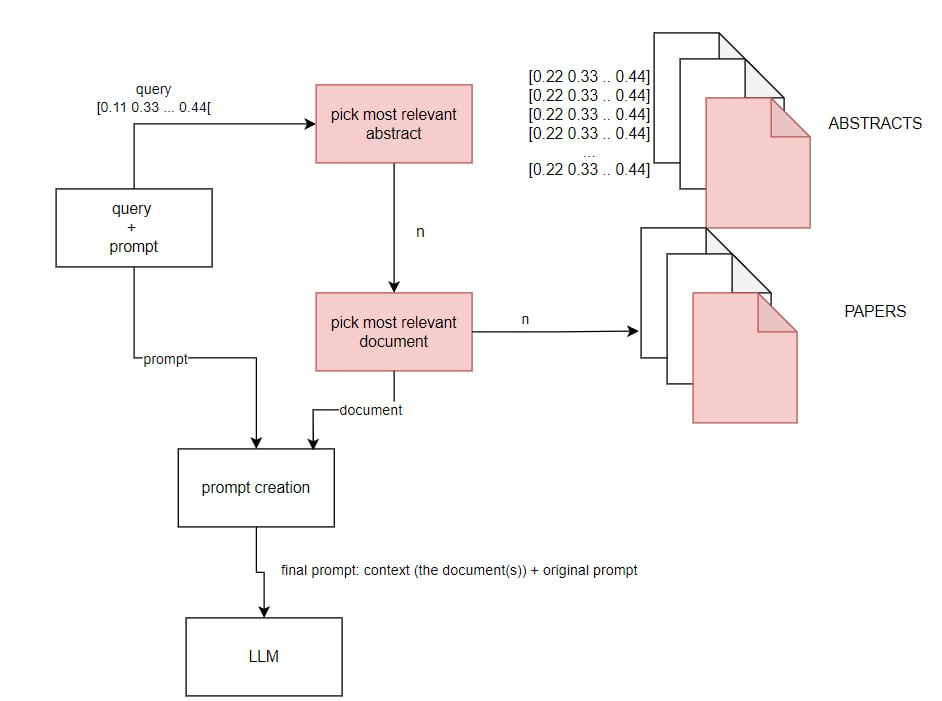

RAG (Retrieval-Augmented Generation) is a powerful framework in Natural Language Processing (NLP) that enhances the performance of language models by combining traditional generative models with external knowledge retrieval. This hybrid approach allows models to retrieve relevant information from a large corpus (like a database or document collection) and incorporate this information into the generation process. It is particularly useful when a model needs to answer questions, generate content, or provide explanations based on real-time or domain-specific data.



In [ ]:
from huggingface_hub import login




import os
import glob
import fitz


#TODO:  Function to extract text from a PDF
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        text += page.get_text()
    return text

    
# Extract text from all PDF files
pdf_texts = {}
directory="."
pdf_files = glob.glob(os.path.join(directory,"paper*.pdf"))
n = 0
for pdf_file in pdf_files:
    pdf_texts[n] = extract_text_from_pdf(pdf_file)
    n = n+1
# your code here...

#Display the text from all the PDF files
for pdf_file, text in pdf_texts.items(): 
    print(f"--- {pdf_file} ---")
    print(text[:500])  # Display the first 500 characters of each document
    print("\n")

### Creating an index of vectors to represent the documents

To perform efficient searches, we need to convert our text data into numerical vectors. To do so, we will use the first step of the BERT transformer.

Since our full pdf files are very long to be fed as input into BERT, we perform a step in which we create a structure where we associate a document number to its abstract, and in a separate dictionary we associate a document number to its full text.


In [ ]:
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np




#import the Bert pretrained model from the transformers library
model_indexing = AutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model_indexing.to("cuda")

#initialization of the dictionary of abstracts. Substitute this with the abstracts of the 10 papers considered as sources for RAG
#(we could use functions to read the PDFs to "cut" the abstracts from the papers. For simplicity reasons, we will copy and paste them)
abstracts_dict = {
    0: """Large Language Models (LLMs) are undergoing a period of rapid updates and changes, with state-
of-the-art (SOTA) model frequently being replaced. When applying LLMs to a specific scientific
field, it’s challenging to acquire unique domain knowledge while keeping the model itself advanced.
To address this challenge, a sophisticated large language model system named as Xiwu has been
developed, allowing you switch between the most advanced foundation models and quickly teach the
model domain knowledge. In this work, we will report on the best practices for applying LLMs in the
field of high-energy physics (HEP), including: a seed fission technology is proposed and some data
collection and cleaning tools are developed to quickly obtain domain AI-Ready dataset; a just-in-time
learning system is implemented based on the vector store technology; an on-the-fly fine-tuning system
has been developed to facilitate rapid training under a specified foundation model.
The results show that Xiwu can smoothly switch between foundation models such as LLaMA, Vicuna,
ChatGLM and Grok-1. The trained Xiwu model is significantly outperformed the benchmark model
on the HEP knowledge Q&A and code generation. This strategy significantly enhances the potential
for growth of our model’s performance, with the hope of surpassing GPT-4 as it evolves with the
development of open-source models. This work provides a customized LLM for the field of HEP,
while also offering references for applying LLM to other fields, the corresponding codes are available
on Github https://github.comzhang/zhengde0225/Xiwu.""",
    1: """
Abstract—With the ubiquitous use of modern large language
models (LLMs) across industries, the inference serving for these
models is ever expanding. Given the high compute and memory
requirements of modern LLMs, more and more top-of-the-
line GPUs are being deployed to serve these models. Energy
availability has come to the forefront as the biggest challenge for
data center expansion to serve these models. In this paper, we
present the trade-offs brought up by making energy efficiency
the primary goal of LLM serving under performance SLOs.
We show that depending on the inputs, the model, and the
service-level agreements, there are several knobs available to
the LLM inference provider to use for being energy efficient.
We characterize the impact of these knobs on the latency,
throughput, as well as the energy. By exploring these trade-
offs, we offer valuable insights into optimizing energy usage
without compromising on performance, thereby paving the way
for sustainable and cost-effective LLM deployment in data center
environments
    """,
    2: """
The rapid adoption of large language models (LLMs) has led to
significant advances in natural language processing and text gener-
ation. However, the energy consumed through LLM model infer-
ence remains a major challenge for sustainable AI deployment. To
address this problem, we model the workload-dependent energy
consumption and runtime of LLM inference tasks on heterogeneous
GPU-CPU systems. By conducting an extensive characterization
study of several state-of-the-art LLMs and analyzing their energy
and runtime behavior across different magnitudes of input prompts
and output text, we develop accurate (𝑅2 >0.96)energy and run-
time models for each LLM. We employ these models to explore
an offline, energy-optimal LLM workload scheduling framework.
Through a case study, we demonstrate the advantages of energy
and accuracy aware scheduling compared to existing best practices
    """,
    3: """
The growing demand for efficient and scalable AI solutions has driven research into optimizing the performance and energy
efficiency of computational infrastructures. The novel concept of redesigning inference clusters and modifying the GPT-Neo
model offers a significant advancement in addressing the computational and environmental challenges associated with AI
deployment. By developing a novel cluster architecture and implementing strategic architectural and algorithmic changes,
the research achieved substantial improvements in throughput, latency, and energy consumption. The integration of advanced
interconnect technologies, high-bandwidth memory modules, and energy-efficient power management techniques, alongside
software optimizations, enabled the redesigned clusters to outperform baseline models significantly. Empirical evaluations
demonstrated superior scalability, robustness, and environmental sustainability, emphasizing the potential for more sustainable
AI technologies. The findings underscore the importance of balancing performance with energy efficiency and provide a robust
framework for future research and development in AI optimization. The research contributes valuable insights into the design
and deployment of more efficient and environmentally responsible AI systems.
1
""",
    4: """
Establishing building energy models (BEMs) for building design and analysis poses significant challenges due to demanding modeling efforts, expertise to use simulation software, and building science knowledge in practice. These make building modeling labor-intensive, hindering its widespread adoptions in building development. Therefore, to overcome these challenges in building modeling with enhanced automation in modeling practice, this paper proposes Eplus-LLM (EnergyPlus-Large Language Model) as the auto-building modeling platform, building on a fine-tuned large language model (LLM) to directly translate natural language description of buildings to established building models of various geometries, occupancy scenarios, and equipment loads. Through fine-tuning, the LLM (i.e., T5) is customized to digest natural language and simulation demands from users and convert human descriptions into EnergyPlus modeling files. Then, the Eplus-LLM platform realizes the automated building modeling through invoking the API of simulation software (i.e., the EnergyPlus engine) to simulate the auto-generated model files and output simulation results of interest. The validation process, involving four different types of prompts, demonstrates that Eplus-LLM reduces over 95% modeling efforts and achieves 100% accuracy in establishing BEMs while being robust to interference in usage, including but not limited to different tones, misspells, omissions, and redundancies. Overall, this research serves as the pioneering effort to customize LLM for auto-modeling purpose (directly build-up building models from natural language), aiming to provide a user-friendly human-AI interface that significantly reduces building modeling efforts. This work also further facilitates large-scale building model efforts, e.g., urban building energy modeling (UBEM), in modeling practice.
""",
5: """
The rapid evolution and widespread adoption of
generative large language models (LLMs) have made them a
pivotal workload in various applications. Today, LLM inference
clusters receive a large number of queries with strict Service
Level Objectives (SLOs). To achieve the desired performance,
these models execute on power-hungry GPUs causing the in-
ference clusters to consume large amount of energy and, conse-
quently, result in excessive carbon emissions. Fortunately, we find
that there is a great opportunity to exploit the heterogeneity in
inference compute properties and fluctuations in inference work-
loads, to significantly improve energy-efficiency. However, such
a diverse and dynamic environment creates a large search-space
where different system configurations (e.g., number of instances,
model parallelism, and GPU frequency) translate into different
energy-performance trade-offs. To address these challenges, we
propose DynamoLLM, the first energy-management framework
for LLM inference environments. DynamoLLM automatically
and dynamically reconfigures the inference cluster to optimize for
energy and cost of LLM serving under the service’s performance
SLOs. We show that at a service-level, DynamoLLM conserves
53 percent energy and 38 percent operational carbon emissions, and reduces
61 percent cost to the customer, while meeting the latency SLOs
""",
6: """
Large language model (LLM) has recently been
considered a promising technique for many fields. This work
explores LLM-based wireless network optimization via in-context
learning. To showcase the potential of LLM technologies, we
consider the base station (BS) power control as a case study,
a fundamental but crucial technique that is widely investigated
in wireless networks. Different from existing machine learning
(ML) methods, our proposed in-context learning algorithm relies
on LLM’s inference capabilities. It avoids the complexity of
tedious model training and hyper-parameter fine-tuning, which is
a well-known bottleneck of many ML algorithms. Specifically, the
proposed algorithm first describes the target task via formatted
natural language, and then designs the in-context learning
framework and demonstration examples. After that, it considers
two cases, namely discrete-state and continuous-state problems,
and proposes state-based and ranking-based methods to select
appropriate examples for these two cases, respectively. Finally, the
simulations demonstrate that the proposed algorithm can achieve
comparable performance as conventional deep reinforcement
learning (DRL) techniques without dedicated model training or
fine-tuning. Such an efficient and low-complexity approach has
great potential for future wireless network optimization.
Index Terms—Large language model, in-context learning, net-
work optimization, transmission power contro
""",
7: """
Both the training and use of Large Language Models (LLMs) require
large amounts of energy. Their increasing popularity, therefore,
raises critical concerns regarding the energy efficiency and sus-
tainability of data centers that host them. This paper addresses the
challenge of reducing energy consumption in data centers running
LLMs. We propose a hybrid data center model that uses a cost-based
scheduling framework to dynamically allocate LLM tasks across
hardware accelerators that differ in their energy efficiencies and
computational capabilities. Specifically, our workload-aware strat-
egy determines whether tasks are processed on energy-efficient
processors or high-performance GPUs based on the number of in-
put and output tokens in a query. Our analysis of a representative
LLM dataset, finds that this hybrid strategy can reduce CPU+GPU
energy consumption by 7.5 percent compared to a workload-unaware
baseline
""",
8: """
Reproducible science requires easy access to data, especially with
the rise of data-driven and increasingly complex models used within
energy research. Too often however, the data to reconstruct and
verify purported solutions in publications is hidden due to some
combination of commercial, legal, and sensitivity issues. This early
work presents our initial efforts to leverage the recent advance-
ments in Large Language Models (LLMs) to create usable and share-
able energy datasets. In particular, we’re utilising their mimicry of
human behaviors, with the goal of extracting and exploring syn-
thetic energy data through the simulation of LLM agents capable of
interacting with and executing actions in controlled environments.
We also analyse and visualise publicly available data in an attempt
to create realistic but not quite exact copies of the originals. Our
early results show some promise, with outputs that resemble the
twin peak curves for household energy consumption. The hope is
that our generalised approach can be used to easily replicate usable
and realistic copies of otherwise secret or sensitive data
""",
9: """
This paper introduces a method for personaliz-
ing energy optimization using large language models (LLMs)
combined with an optimization solver. This approach, termed
human-guided optimization autoformalism, translates natural
language specifications into optimization problems, enabling
LLMs to handle various user-specific energy-related tasks. It
allows for nuanced understanding and nonlinear reasoning
tailored to individual preferences. The research covers common
energy sector tasks like electric vehicle charging, HVAC control,
and long-term planning for renewable energy installations. This
novel strategy represents a significant advancement in context-
based optimization using LLMs, facilitating sustainable energy
practices customized to individual needs
"""
}

#the text for rag is used as an input to the BERT model

#The tokenized inputs are passed to the BERT model for processing.
#(#remember padding=True: Ensures that all inputs are padded to the same length, allowing batch processing.)
#The model outputs a tensor (last_hidden_state), where each input token is represented by a high-dimensional vector.
#last_hidden_state is of shape (batch_size, sequence_length, hidden_size), where:
#batch_size: Number of input texts.
#sequence_length: Length of each tokenized text (after padding).
#hidden_size: Dimensionality of the vector representation for each token (default 768 for bert-base-uncased).

#last_hidden_state[:, 0]: Selects the representation of the [CLS] token for each input text. The [CLS] token is a special token added at the start of each input and is often used as the aggregate representation for the entire sequence.
tokenized_inputs = tokenizer(list(abstracts_dict.values()), return_tensors='pt', padding=True)
tokenized_inputs = {key: value.to("cuda") for key, value in tokenized_inputs.items()}

abstract_vectors = model_indexing(**tokenized_inputs).last_hidden_state[:, 0]


#abstract_vectors is a tensor of shape (batch_size, hidden_size) (e.g., (3, 768) in this case), representing each text as a single 768-dimensional vector.

print(abstract_vectors.shape)



### Search

With our text data vectorized and indexed, we can now perform searches. We will define a function to search the index for the most relevant documents based on a query.

To perform the search, we need a function (search documents) where we perform the cosine similarity between the query vector and all the abstract vectors. This function will give our the top-k indexes. Once we find the top-k indexes, with another function, we can collect the full text of the documents from the paper dictionary.

To compute cosine similarity, refer to the following formula

```cs = cosine_similarity(vector_a.detach().numpy(), vector_b.detach().numpy())```




In [ ]:
device = "cuda"

def get_top_k_similar_indices(query_vector, abstract_vectors, k):
    """
    Computes the top k indices of the most similar abstracts to the query based on cosine similarity.
    
    Parameters:
    - query_vector: A tensor of shape (1, hidden_size) representing the query vector.
    - abstract_vectors: A tensor of shape (batch_size, hidden_size) representing the abstract vectors.
    - k: The number of top indices to return.
    
    Returns:
    - sorted_indices: A numpy array of shape (1, k) containing the indices of the top k most similar abstracts.
    """
    # Compute cosine similarity between the query and each abstract
    similarities = cosine_similarity(query_vector.cpu().detach().numpy(), abstract_vectors.cpu().detach().numpy())
    
    # Sort the indices by similarity in descending order
    sorted_indices = np.argsort(similarities, axis=1)[:, ::-1]
    
    # Return the top k indices
    return sorted_indices[:, :k]


def retrieve_documents(indices, documents_dict):
    
    #Retrieves the documents corresponding to the given indices and concatenates them into a single string.
    
    #Parameters:
    #- indices: A numpy array or list of top-k indices of the most similar documents.
    #- documents_dict: A dictionary where keys are document indices (integers) and values are the document texts (strings).
    
    #Returns:
    #- concatenated_documents: A string containing the concatenated texts of the retrieved documents.
    
    # Retrieve the documents corresponding to the indices
    retrieved_docs = [documents_dict[i] for i in indices[0]]  # Assuming indices is a 2D array
    
    # Concatenate the documents into a single string
    concatenated_documents = " ".join(retrieved_docs)
    
    return concatenated_documents


#now I create a vector also for my query 

query = "energy topics covered by papers with large language models"

tokenized_query = tokenizer(query, return_tensors='pt')

# Move the tokenized query to the same device as the model
tokenized_query = {key: value.to(device) for key, value in tokenized_query.items()}

# Now pass the tokenized query to the model
query_vector = model_indexing(**tokenized_query).last_hidden_state[:, 0]

print(f"Model is on device: {model_indexing.device}")
print(f"Query tensor is on device: {tokenized_query['input_ids'].device}")


indices = get_top_k_similar_indices(query_vector, abstract_vectors, 1)

print("BEST DOCUMENTS: {indices}")

print(f"best index: {indices}")


concatenated_documents=retrieve_documents(indices, pdf_texts)








### A function to perform Retrieval Augmented Generation

In this step, we’ll combine the context retrieved from our documents with LLAMA to generate responses. The context will provide the necessary information to the model to produce more accurate and relevant answers.

In [ ]:
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import datetime


model_id = "meta-llama/Llama-3.2-3B"
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, device_map="cuda")
tokenizer = AutoTokenizer.from_pretrained(model_id)
device = "cuda"

query_for_rag = "What are the main energy issues for Large Language Models?"

new_system_prompt = """<<SYS>> You are a helpful, respectful and honest assistant. \
    Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, \
    unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses \
    are socially unbiased and positive in nature. If a question does not make any sense, or is not factually \
    coherent, explain why instead of answering something not correct. If you don't know the answer to a question, \
    please don't share false information.
    Provide straight to the point answers, without bullet points.
<</SYS>>"""


#now embed the result of the previous prompt in a new prompt to ask some additional information (i.e., the year of foundation). you have to split the original prompt to create a new one

p_not_augmented =  """{SYS}\nQuestion: {PROMPT}. \nAnswer:""".format(SYS=new_system_prompt, PROMPT=query_for_rag)


print(p_not_augmented)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id


inputs = tokenizer(p_not_augmented, return_tensors="pt", padding=True, truncation=True).to(device)



# Generate a response
output = model.generate(
    inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_length=500,
    max_new_tokens=300,  # Limit output to a reasonable size (adjust as needed)
    top_k=10,  # Sampling parameters
    num_return_sequences=1,  # Generate a single response
    temperature=0.7,  # Adjust randomness
    repetition_penalty=1.0,  # Reduce repetition
    length_penalty=1.0,  # Penalize longer responses
    eos_token_id=tokenizer.eos_token_id,  # End generation at EOS token
    pad_token_id=tokenizer.pad_token_id,  # Avoid padding tokens
    early_stopping=True  # Stop once the model generates the response
)

# Decode the response into human-readable text
r_not_augmented = tokenizer.decode(output[0], skip_special_tokens=True).strip()

print(r_not_augmented)










In [ ]:
#now the same for the augmented one


p_augmented =  """{SYS}\nQuestion: {PROMPT} Collect information from the following article: {BODY}. \nAnswer:""".format(SYS=new_system_prompt, BODY=concatenated_documents, PROMPT=query_for_rag)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id


inputs = tokenizer(p_augmented, return_tensors="pt", padding=True, truncation=True).to(device)

output = model.generate(
    inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_length=500,
    max_new_tokens=300,  # Limit output to a reasonable size (adjust as needed)
    top_k=10,  # Sampling parameters
    num_return_sequences=1,  # Generate a single response
    temperature=0.7,  # Adjust randomness
    repetition_penalty=1.0,  # Reduce repetition
    length_penalty=1.0,  # Penalize longer responses
    eos_token_id=tokenizer.eos_token_id,  # End generation at EOS token
    pad_token_id=tokenizer.pad_token_id,  # Avoid padding tokens
    early_stopping=True  # Stop once the model generates the response
)

# Decode the response into human-readable text
r_augmented = tokenizer.decode(output[0], skip_special_tokens=True).strip()

print(r_augmented)